# GPU Hello World

### Task 3

1. Make a NumPy matrix
2. Install, import and initialize PyCUDA
3. Make a GPU matrix
4. Copy the NumPy matrix data to the GPU
5. Write a GPU *kernel* that does some kind of computation on an input matrix
6. Copy the result back to the CPU
7. Print and plot both matrices

### Solution 3

<-- see `hello_world_pycuda_solution.ipynb`

In [1]:
print("Hello world")

Hello world


In [4]:
i = 9

In [5]:
i = i + 2

In [6]:
print(i)

11


In [7]:
!nvidia-smi

Thu Jan 23 16:22:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%time
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp311-cp311-linux_x86_64.whl size=660362 sha256=a1dc38a6a967a4a2469b9ee26c18567a4d8d5f259ab61b48582454ff327ce89c
  Stored in directory: /root/.cache/pip/wheels/76/66/50/c65e6116d7e0e16abe0f7c19b50327f76724ccfefbdc61a1b9
Successfully built pycuda
CPU times: user 729 ms, sys: 108 ms, total: 838 ms
Wall time: 2min 22s


In [8]:
#Import pycuda and specific submodules

import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

In [9]:
#Remember to initialize CUDA!!!
import pycuda.autoinit

In [10]:
#import Numpy to generate numbers on the CPU
import numpy as np

In [11]:
#First, generate some random numbers on the CPU
a = np.random.randn(4,4).astype(dtype=np.float32)
print(a)

[[ 0.98832494 -0.6792337   0.40006799  0.930256  ]
 [ 1.8090439   0.26812035 -0.8391215  -1.0884448 ]
 [ 1.1061832  -0.2878027  -0.2635892  -0.54905486]
 [ 0.8695573   0.14726733  0.11836702  0.12111064]]


In [12]:
#Print some information about a:
print(a.dtype)
print(a.nbytes)

float32
64


In [13]:
#Double check if size makes sense:
a_num_elements = 4*4
num_bytes_per_element = 4 #NB: single precision is 4 bytes, double 8
print(a_num_elements*num_bytes_per_element)

64


In [14]:
#Transfer the data to the GPU (and allocate data there)
a_gpu = cuda.mem_alloc(a.nbytes)

In [15]:
#Copy data from host (cpu, numpy, a) to device (gpu, pycuda, a_gpu)
cuda.memcpy_htod(a_gpu, a)

In [16]:
kernel_src = """
//Important: This expects a_gpu to be single precision numbers,
//           not double precision
__global__ void double_a(float* a_gpu) {
    int tid = threadIdx.x + threadIdx.y * 4;

    a_gpu[tid] = a_gpu[tid]*2;
}
"""

mod = SourceModule(kernel_src) #Create the source module from the source code
func = mod.get_function("double_a") #Get the compiled function double_a from the source code

In [17]:
func(a_gpu, block=(4,4,1),grid=(1,1,1))

In [18]:
#print out what a_gpu is:
b = np.empty_like(a) #create an empty array equal in datatype and size to al
cuda.memcpy_dtoh(b, a_gpu)

print(a)
print(b)

print(2*a-b)

[[ 0.98832494 -0.6792337   0.40006799  0.930256  ]
 [ 1.8090439   0.26812035 -0.8391215  -1.0884448 ]
 [ 1.1061832  -0.2878027  -0.2635892  -0.54905486]
 [ 0.8695573   0.14726733  0.11836702  0.12111064]]
[[ 1.9766499  -1.3584673   0.80013597  1.860512  ]
 [ 3.6180878   0.5362407  -1.678243   -2.1768897 ]
 [ 2.2123663  -0.5756054  -0.5271784  -1.0981097 ]
 [ 1.7391146   0.29453465  0.23673403  0.24222128]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [19]:
from matplotlib import pyplot as plt

[ 0.98832494 -0.6792337   0.40006799  0.930256  ]
[ 1.9766499  -1.3584673   0.80013597  1.860512  ]


Text(0.5, 1.0, 'Publish this graph')

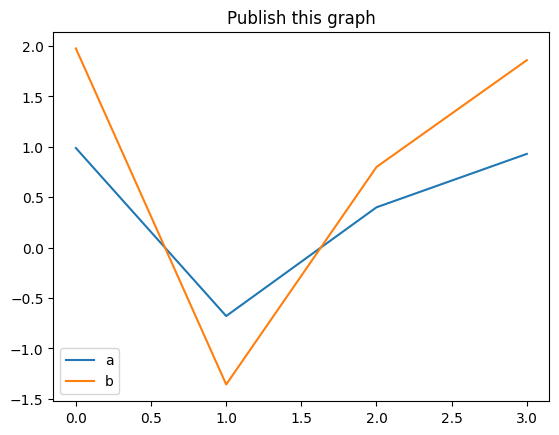

In [20]:
print(a[0,:])
print(b[0,:])

plt.plot(a[0,:], label='a')
plt.plot(b[0,:], label='b')
plt.legend()
plt.title('Publish this graph')